In [272]:
import numpy as np
import pandas as pd
from numpy.random import randn
import scipy
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.transforms as mtransforms
import imp
import align_utils
import pf_utils
imp.reload(align_utils)
imp.reload(pf_utils)

from align_utils import *
from pf_utils import *

import random
import particle_filter
imp.reload(particle_filter)
from particle_filter import *
import pandas as pd
from tqdm import tqdm

import cv2
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

In [273]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [274]:
img = plt.imread("BF1.png")

In [275]:
H = img.shape[0]
W = img.shape[1]

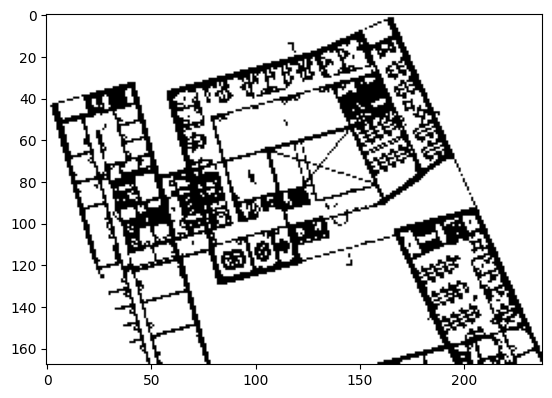

In [276]:
img_rescaled = rescale(img[:, :, 0], 0.1, anti_aliasing=True)
threshold = 0.8
img_thresh = np.where(img_rescaled > threshold, 1, 0)
plt.imshow(img_thresh, cmap='gray')

In [277]:
img_walk = plt.imread("BF1_walkable.png")

In [278]:
imgwlk_rescaled = rescale(img_walk[:, :, 0], 0.1, anti_aliasing=False)

In [279]:
erosion_size = 1
element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, 
                                    (2 * erosion_size + 1, 2 * erosion_size + 1), 
                                    (erosion_size, erosion_size))
erosion_dst = cv2.erode(imgwlk_rescaled, element)

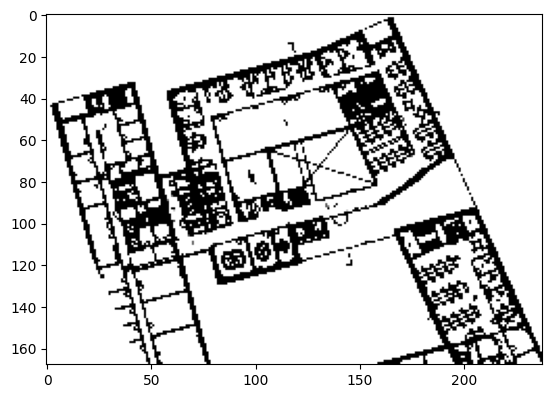

In [280]:
map_for_crf = np.clip(erosion_dst+img_thresh, 0.0, 1.0)
plt.imshow(map_for_crf, cmap='gray')

In [281]:
np.save('map.npy', map_for_crf * 255)

In [282]:
np.save('map_original.npy', img * 255)

In [283]:
map_for_crf.shape

(168, 238)

In [284]:
WIDTH = map_for_crf.shape[1]
HEIGHT = map_for_crf.shape[0]
dim = (WIDTH, HEIGHT)
NEIGHBOR_SHIFT = 2
NEIGHBOR_LENGTH = NEIGHBOR_SHIFT*2+1
NEIGHBOR = NEIGHBOR_LENGTH*NEIGHBOR_LENGTH

In [285]:
bordered = np.zeros([HEIGHT+2*NEIGHBOR_SHIFT, WIDTH+2*NEIGHBOR_SHIFT])
bordered[NEIGHBOR_SHIFT:HEIGHT+NEIGHBOR_SHIFT, NEIGHBOR_SHIFT:WIDTH+NEIGHBOR_SHIFT] = map_for_crf

(-0.5, 241.5, 171.5, -0.5)

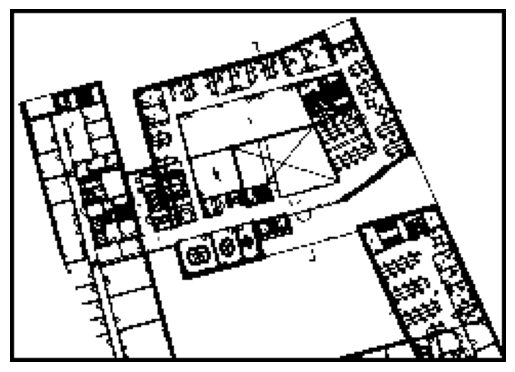

In [286]:
plt.imshow(bordered, cmap='gray')
plt.axis('off')

In [287]:
shifted = np.zeros([HEIGHT+2*NEIGHBOR_SHIFT, WIDTH+2*NEIGHBOR_SHIFT, NEIGHBOR])
for idx in range(NEIGHBOR):
    y, x = np.unravel_index(idx, (NEIGHBOR_LENGTH, NEIGHBOR_LENGTH))
    shifted[y:HEIGHT + y, x:WIDTH + x, idx] = map_for_crf
shifted_flip = np.flip(shifted, axis=2)
cut = shifted_flip[NEIGHBOR_SHIFT:HEIGHT+NEIGHBOR_SHIFT, NEIGHBOR_SHIFT:WIDTH+NEIGHBOR_SHIFT, :]

In [288]:
occupancy = ~ cut.astype(bool)

In [289]:
transfer_matrix = np.zeros(occupancy.shape).astype(bool)

In [290]:
transfer_matrix[:,:,0] = occupancy[:,:,0]|occupancy[:,:,6]|(occupancy[:,:,1]&occupancy[:,:,5])|(occupancy[:,:,7]&occupancy[:,:,11])
transfer_matrix[:,:,4] = occupancy[:,:,4]|occupancy[:,:,8]|(occupancy[:,:,3]&occupancy[:,:,9])|(occupancy[:,:,7]&occupancy[:,:,13])
transfer_matrix[:,:,20] = occupancy[:,:,20]|occupancy[:,:,16]|(occupancy[:,:,15]&occupancy[:,:,21])|(occupancy[:,:,11]&occupancy[:,:,17])
transfer_matrix[:,:,24] = occupancy[:,:,24]|occupancy[:,:,18]|(occupancy[:,:,19]&occupancy[:,:,23])|(occupancy[:,:,13]&occupancy[:,:,17])
transfer_matrix[:,:,1] = occupancy[:,:,1]|(occupancy[:,:,6]&occupancy[:,:,7])|(occupancy[:,:,6]&occupancy[:,:,2])|(occupancy[:,:,7]&occupancy[:,:,11])
transfer_matrix[:,:,3] = occupancy[:,:,3]|(occupancy[:,:,7]&occupancy[:,:,8])|(occupancy[:,:,2]&occupancy[:,:,8])|(occupancy[:,:,7]&occupancy[:,:,13])
transfer_matrix[:,:,5] = occupancy[:,:,5]|(occupancy[:,:,6]&occupancy[:,:,11])|(occupancy[:,:,6]&occupancy[:,:,10])|(occupancy[:,:,7]&occupancy[:,:,11])
transfer_matrix[:,:,9] = occupancy[:,:,9]|(occupancy[:,:,8]&occupancy[:,:,13])|(occupancy[:,:,8]&occupancy[:,:,14])|(occupancy[:,:,7]&occupancy[:,:,13])
transfer_matrix[:,:,15] = occupancy[:,:,15]|(occupancy[:,:,11]&occupancy[:,:,16])|(occupancy[:,:,10]&occupancy[:,:,16])|(occupancy[:,:,11]&occupancy[:,:,17])
transfer_matrix[:,:,19] = occupancy[:,:,19]|(occupancy[:,:,13]&occupancy[:,:,18])|(occupancy[:,:,14]&occupancy[:,:,18])|(occupancy[:,:,13]&occupancy[:,:,17])
transfer_matrix[:,:,21] = occupancy[:,:,21]|(occupancy[:,:,16]&occupancy[:,:,17])|(occupancy[:,:,16]&occupancy[:,:,22])|(occupancy[:,:,11]&occupancy[:,:,17])
transfer_matrix[:,:,23] = occupancy[:,:,23]|(occupancy[:,:,17]&occupancy[:,:,18])|(occupancy[:,:,18]&occupancy[:,:,22])|(occupancy[:,:,13]&occupancy[:,:,17])
transfer_matrix[:,:,6] = occupancy[:,:,6]
transfer_matrix[:,:,7] = occupancy[:,:,7]
transfer_matrix[:,:,8] = occupancy[:,:,8]
transfer_matrix[:,:,11] = occupancy[:,:,11]
transfer_matrix[:,:,12] = occupancy[:,:,12]
transfer_matrix[:,:,13] = occupancy[:,:,13]
transfer_matrix[:,:,16] = occupancy[:,:,16]
transfer_matrix[:,:,17] = occupancy[:,:,17]
transfer_matrix[:,:,18] = occupancy[:,:,18]
transfer_matrix[:,:,2] = occupancy[:,:,2]|occupancy[:,:,7]
transfer_matrix[:,:,10] = occupancy[:,:,10]|occupancy[:,:,11]
transfer_matrix[:,:,14] = occupancy[:,:,14]|occupancy[:,:,13]
transfer_matrix[:,:,22] = occupancy[:,:,22]|occupancy[:,:,17]

(-0.5, 237.5, 167.5, -0.5)

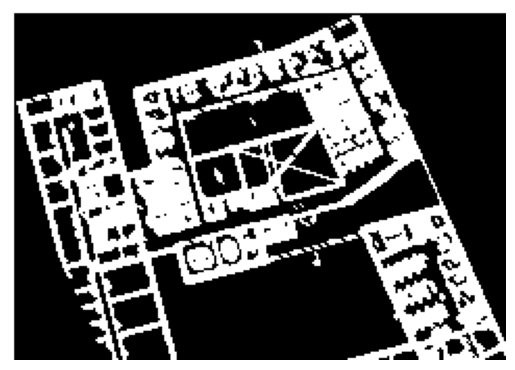

In [291]:
plt.imshow(transfer_matrix[:, :, 0], cmap='gray')
plt.axis('off')

In [292]:
transfer_matrix.shape

(168, 238, 25)

In [293]:
np.save('./pre/map_transition.npy', transfer_matrix.astype(bool))

In [294]:
img_out = plt.imread("BF1_outofbuilding.png")

(-0.5, 237.5, 167.5, -0.5)

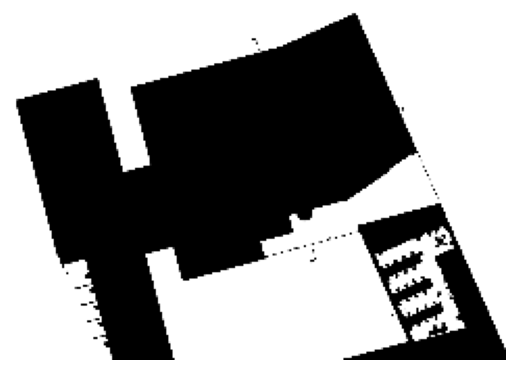

In [295]:
imgout_rescaled = 1.0 - rescale(img_out[:, :, 0], 0.1, anti_aliasing=False)
plt.imshow(imgout_rescaled, cmap='gray')
plt.axis('off')

In [296]:
shifted = np.ones([HEIGHT+2*NEIGHBOR_SHIFT, WIDTH+2*NEIGHBOR_SHIFT, NEIGHBOR])
for idx in range(NEIGHBOR):
    y, x = np.unravel_index(idx, (NEIGHBOR_LENGTH, NEIGHBOR_LENGTH))
    shifted[y:HEIGHT + y, x:WIDTH + x, idx] = imgout_rescaled
shifted_flip = np.flip(shifted, axis=2)
cut = shifted_flip[NEIGHBOR_SHIFT:HEIGHT+NEIGHBOR_SHIFT, NEIGHBOR_SHIFT:WIDTH+NEIGHBOR_SHIFT, :]

In [297]:
np.save('./pre/map_unary.npy', cut.astype(bool))

In [298]:
img_rescaled.shape

(168, 238)

In [299]:
seq = 16
inertial = np.loadtxt('./data/seq_'+str(seq)+'.txt')

traj_imu = [[0, 0]]
for i in inertial:
    traj_imu.append([traj_imu[-1][0]+i[3]/2, traj_imu[-1][1]+i[4]/2])
    traj_imu.append([traj_imu[-1][0]+i[3]/2, traj_imu[-1][1]+i[4]/2])
traj_imu = np.array(traj_imu)

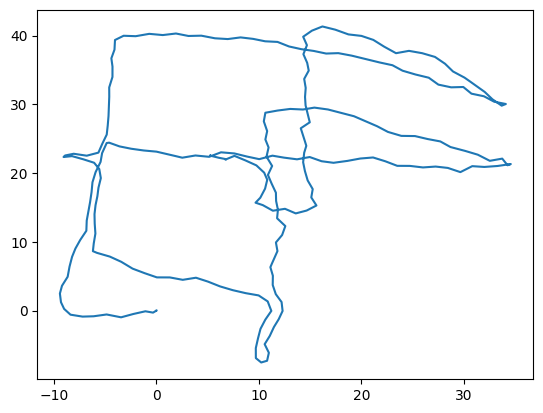

In [300]:
plt.plot(traj_imu[:, 0], traj_imu[:, 1])

In [301]:
np.save('./pre/trajectory.npy', traj_imu)

In [302]:
traj_imu.shape

(613, 2)

# Discretize Trajectory

Resolution is 7.2 pixel per inch.

In [303]:
meter2pix = 39.3701 * 72 / 100 / 10

In [304]:
seq = 16
inertial = np.loadtxt('./data/seq_'+str(seq)+'.txt')

traj_imu = [[0, 0]]
for i in inertial:
    traj_imu.append([traj_imu[-1][0]+i[3], traj_imu[-1][1]+i[4]])
traj_imu = np.array(traj_imu)

In [305]:
traj_imu_int = (traj_imu * meter2pix).astype('int')

In [306]:
# traj_imu_int

In [307]:
traj_imu_int[1:].shape

(306, 2)

In [308]:
traj_imu_int[:-1].shape

(306, 2)

In [309]:
traj_diff = traj_imu_int[1:] - traj_imu_int[:-1]
traj_diff_1 = traj_diff // 2
traj_diff_2 = traj_diff - traj_diff_1
traj_diff_new = np.concatenate((traj_diff_1[:, np.newaxis, :], traj_diff_2[:, np.newaxis, :]), axis=1)
traj_diff_new = traj_diff_new.reshape(-1, 2)
traj_diff_new = np.clip(traj_diff_new, -2, 2)

In [310]:
# np.set_printoptions(threshold=np.inf)
traj_diff_new.shape

(612, 2)

In [311]:
traj_from_diff = [np.array([0, 0])]
for i in traj_diff_new:
    traj_from_diff.append(i + traj_from_diff[-1])
traj_from_diff = np.array(traj_from_diff)

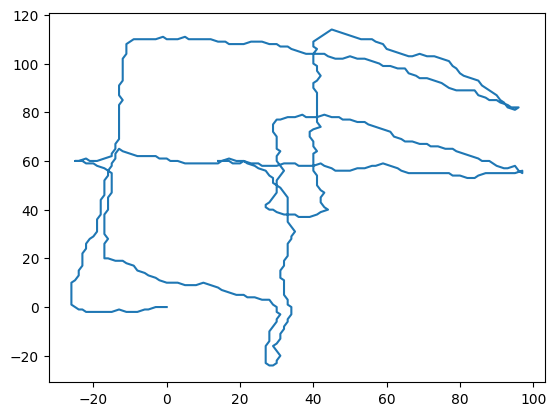

In [312]:
plt.plot(traj_from_diff[:, 0], traj_from_diff[:, 1])

In [313]:
traj_from_diff[119,]


array([-16,  56])

In [314]:
traj_from_diff[:, 1] = -traj_from_diff[:,1]
traj_from_diff = np.flip(traj_from_diff, axis=1)

In [315]:
np.save('./pre/trajectory_discrete.npy', traj_from_diff)

In [316]:
traj_from_diff.shape

(613, 2)

# Discretize WiFi Localization

In [317]:
seq = 16
inertial = np.loadtxt('./data/seq_'+str(seq)+'.txt')
inertial_ts = inertial[:, 0]
# wifi = pd.read_pickle("seq_"+str(23)+".pickle")
# # # # wifi1 = pd.read_pickle("data/bayes_radiomap.pickle")

# # wifi_ts = [float(i)/10 for i in wifi.keys()]
# wifi_keys = list(wifi.keys())
# wifi_localization = np.array([wifi[i][:, :2] for i in wifi_keys])
# wifi_localization.shape

In [318]:
wifi = np.load('./data/AE.npy')
wifi_keys = list(wifi[:,0])
len(wifi_keys)

790

0
178
39259124.0
39306734.0
(3911, 2)
(4347, 2)


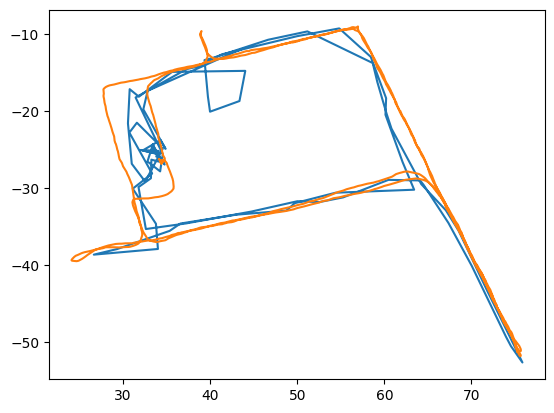

In [331]:

wifi_ts = [float(i)/10 for i in wifi[:,0]]

wifi_localization = wifi[:,1:3]
t_start = find_nearest(wifi_keys,inertial_ts[0])
t_end = find_nearest(wifi_keys,inertial_ts[-1])
print(t_start)
print(t_end)
# print(wifi_keys[637])
print(inertial_ts[0])
print(inertial_ts[-1])

online_traj = wifi_localization[t_start:t_end+1,:]
online_sync = online_traj[2::2]
gt2 = np.load("data/gt_23.npy")
gt15 = np.load("data/gt_15.npy")
gt15 = gt15[:,1:]
gt16 = np.load("data/gt_16.npy")
gt16 = gt16[:,1:]
gt = gt2[:,1:]
print(gt15.shape)
print(gt.shape)
gt = np.vstack([gt16])
plt.plot(online_sync[:, 0], online_sync[:, 1])
plt.plot(gt[:, 0], gt[:, 1])

wifi_localization = wifi_localization[t_start:t_end+1,:]
wifi_keys = wifi_keys[t_start:t_end+1]


In [320]:
# wifi_localization_discrete = (wifi_localization * meter2pix).astype('int')
# wifi_localization_discrete.shape

mean = 0
stddev = 0.1  # Adjust the standard deviation as per your requirement
gaussian_noise = np.random.normal(mean, stddev, size=(179,5, 2))

# Expand dimensions
expanded_vector = np.expand_dims(wifi_localization, axis=1)
repeated_vector = np.repeat(expanded_vector, 5, axis=1)
# reshaped_noise = gaussian_noise.reshape(repeated_vector.shape)
noisy_vector = repeated_vector + gaussian_noise
wifi_localization_discrete = (noisy_vector * meter2pix).astype('int')
wifi_localization_discrete.shape
# gaussian_noise

(179, 5, 2)

In [321]:
inertial_ts_discrete = np.repeat(inertial_ts, 2)
# inertial_ts_discrete

In [322]:
location_idx = []
for ts in wifi_keys:
    location_idx.append(find_nearest(inertial_ts, ts))

In [323]:
wifi_localization_synced = np.zeros([inertial_ts_discrete.shape[0],5, 2]).astype('int')
wifi_localization_mask = np.zeros([inertial_ts_discrete.shape[0]]).astype('bool')

In [324]:
for wifi_i, imu_i in enumerate(location_idx):
    wifi_localization_mask[imu_i*2] = True
    wifi_localization_synced[imu_i*2] = wifi_localization_discrete[wifi_i]

In [325]:
wifi_localization_mask.shape


(612,)

In [326]:
wifi_localization_synced.shape

(612, 5, 2)

In [327]:
wifi_localization_synced[:, :, 1] = -wifi_localization_synced[:, :, 1]
wifi_localization_synced = np.flip(wifi_localization_synced, axis=2)
wifi_localization_synced.shape

(612, 5, 2)

In [328]:
np.save('pre/localization.npy', wifi_localization_synced)

In [329]:
np.save('pre/localization_bool.npy', wifi_localization_mask)

In [364]:
blank = np.zeros((168, 238))

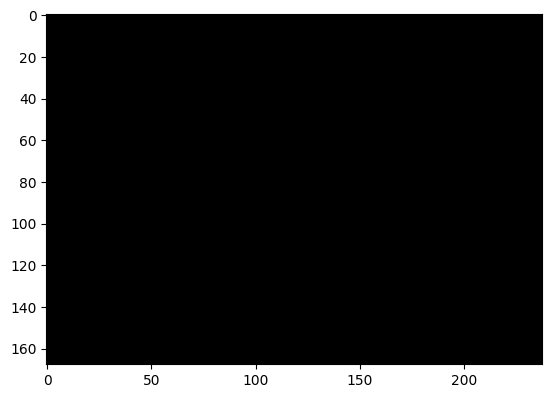

In [365]:
plt.imshow(blank, cmap='gray')

In [366]:
def gaussian_kernel(size, sigma):
    # Create an (size x size) grid of coordinates
    x, y = np.mgrid[-(size // 2):(size // 2) + 1, -(size // 2):(size // 2) + 1]

    # Calculate the 2D Gaussian function at each coordinate
    kernel = np.exp(-(x ** 2 + y ** 2) / (2 * sigma ** 2))

    # Normalize the kernel so that the sum of its elements is 1
    kernel /= kernel.sum()

    return kernel

# Example usage:
size = 5
sigma = 2
kernel = gaussian_kernel(size, sigma)
print(kernel)

[[0.02324684 0.03382395 0.03832756 0.03382395 0.02324684]
 [0.03382395 0.04921356 0.05576627 0.04921356 0.03382395]
 [0.03832756 0.05576627 0.06319146 0.05576627 0.03832756]
 [0.03382395 0.04921356 0.05576627 0.04921356 0.03382395]
 [0.02324684 0.03382395 0.03832756 0.03382395 0.02324684]]


In [367]:
x = 200
y = 100
blank[y-3:y+2, x-3:x+2] = kernel

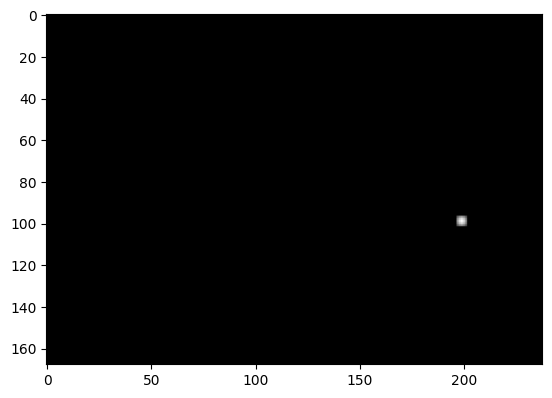

In [368]:
plt.imshow(blank, cmap='gray')

In [ ]:
# for (x, y) in traj_imu_int:
#     print(x)

In [ ]:
# online_traj = np.load('online.npy')
# online_traj

In [ ]:
# ae = np.load('data/AE.npy')
# ae[:, 1:3]

In [ ]:
# online_traj = np.load('online.npy')
ae = np.load('data/AE.npy')
online_traj = ae[:, 1:3]
# print(online_traj.shape)
# online_traj[:, 0] = -online_traj[:, 0]
# online_traj = np.flip(online_traj, axis=1)
# online_traj = online_traj / meter2pix
online_traj.shape

In [ ]:
online_sync = online_traj[2::2]

In [ ]:
online_sync.shape

In [ ]:
online_traj.shape

In [ ]:
# gt = np.load("23_gt.npy")
gt2 = np.load("data/gt_23.npy")
gt = gt2[:,1:]
# plt.plot(online_sync[:, 0], online_sync[:, 1])
# plt.plot(gt[:, 0], gt[:, 1])
gt.shape


In [ ]:
# gt = np.load("23_gt.npy")

In [ ]:
np.average(np.linalg.norm(online_sync - gt, axis=1))

In [ ]:
def draw_cdf(data,ax,K):
    data = np.array(data).astype(float)
    count, bins_count = np.histogram(data, bins=25)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    ax.plot(bins_count[1:], cdf, label=f"{K}")
    ax.legend()
    return ax

In [ ]:
pf_online = np.load('./23_online.npy')  # [286, 3]
pf_gt = np.load('./23_gt.npy')  # [286, 2]

In [ ]:
ax = plt.subplot()
plt.rcParams["figure.figsize"] = (4,4)
draw_cdf(np.linalg.norm(pf_online[:, :2] - pf_gt, axis=1), ax,"PF")
draw_cdf(np.linalg.norm(online_sync - gt, axis=1), ax,"CRF")
# draw_cdf(distancec,ax,"imu uncer")

In [ ]:
np.linalg.norm(online_sync - gt, axis=1)

In [ ]:
online_traj

In [ ]:
online_traj[:, 0] = -online_traj[:, 0]
online_traj = np.flip(online_traj, axis=1)